# FLappy bird

In [ ]:
import random
import matplotlib.pyplot as plt
import subprocess
import tempfile
import json

def train(run_game_function, weight_size, generations=1000, epsilon=0, epsilon_decay=1, name="No Name", nameOfTheFile="jeuClassique.py"):
    best_weights = [random.uniform(-1, 1) for _ in range(weight_size)]
    best_score = run_game_function(best_weights)

    epsilon_min = 0
    scores = []
    moving_avg = []
    epsilons = []

    for gen in range(generations):
        epsilons.append(epsilon)

        if random.random() < epsilon:
            weights = [random.uniform(-2, 2) for _ in range(weight_size)]
        else:
            weights = [w + random.uniform(-0.2, 0.2) for w in best_weights]

        score = run_game_function(weights)

        scores.append(score)
        avg = sum(scores[-100:]) / min(len(scores), 100)
        moving_avg.append(avg)

        print(f"Generation {gen} | Score: {score:.2f} | ε={epsilon:.4f}")

        if score > best_score:
            best_score = score
            best_weights = weights
            print("🎉 New best score:", best_score)

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print("\n--- Training complete ---")
    print("Best score:", best_score)
    print("Best weights found:", best_weights)
    final_weights = best_weights

    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Generations")
    ax1.set_ylabel("Score", color='tab:blue')
    ax1.plot(scores, label="Scores", color='tab:blue', alpha=0.5)
    ax1.plot(moving_avg, label="Moving average (100 generations)", color='tab:red', linestyle='dashed')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel("ε (Epsilon)", color='tab:green')
    ax2.plot(epsilons, label="Epsilon", color='tab:green', linestyle='dotted')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    fig.tight_layout()
    plt.title(name)
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()

    print("Launching a game with the best weights...")

    with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.json') as f:
        json.dump(final_weights, f)
        temp_file_path = f.name

    subprocess.run(["python", nameOfTheFile, temp_file_path])

    print("\n--- Evaluating final weights over 100 games ---")
    final_scores = [run_game_function(final_weights) for _ in range(100)]

    avg_score = sum(final_scores) / len(final_scores)
    std_dev = (sum((x - avg_score) ** 2 for x in final_scores) / len(final_scores)) ** 0.5
    min_score = min(final_scores)
    max_score = max(final_scores)

    print("\n✅ Final Weights Evaluation (100 games):")
    print(f"- Average score: {avg_score:.2f}")
    print(f"- Standard deviation: {std_dev:.2f}")
    print(f"- Min score: {min_score}")
    print(f"- Max score: {max_score}")

    plt.figure(figsize=(10, 5))
    plt.hist(final_scores, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(avg_score, color='red', linestyle='dashed', linewidth=1.5, label=f"Avg: {avg_score:.2f}")
    plt.axvline(min_score, color='gray', linestyle='dotted', linewidth=1.5, label=f"Min: {min_score}")
    plt.axvline(max_score, color='green', linestyle='dotted', linewidth=1.5, label=f"Max: {max_score}")
    plt.title(f"{name} - Final Score Distribution (100 Games)")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()


## Flappy bird CLASSIC

In [ ]:
from jeuClassique import run_game as run_game_classique

I am adding the decision function directly here because the python files of the game has a lot of duplicated code between each version of the game.

```python
def should_jump(bird, pipes, weights):
    ...
    decision = (weights[0] * dy_top + 
                weights[1] * dy_bottom + 
                weights[2] * dx + 
                weights[3] * v + 
                weights[4] * altitude) 

    return decision < 0
```

### Epsilon greedy

1000 generations

epsilon=0.1

epsilon_decay=1 (no decaying)

In [ ]:
train(run_game_function=run_game_classique, weight_size=5, generations=1000, epsilon=0.1, epsilon_decay=1, name="Mode Classique", nameOfTheFile="jeuClassique.py")

### Epsilon greedy decaying

 generations=1000
 
 epsilon=1 (initial)
 
 epsilon_decay=0.995 (decaying)

In [ ]:
train(run_game_function=run_game_classique, weight_size=5, generations=1000, epsilon=1, epsilon_decay=0.995, name="Mode Classique", nameOfTheFile="jeuClassique.py")

### Gredy simple

generations=1000

epsilon=0 (no exploration)

epsilon_decay=0

In [ ]:
train(run_game_function=run_game_classique, weight_size=5, generations=1000, epsilon=0, epsilon_decay=0, name="Mode Classique", nameOfTheFile="jeuClassique.py")

# Comparison of the 3 learning methods

this code will run the 3 methods multiple times to compare them 

(we used parallelization but it's not speeding the process)

In [ ]:
import random
import matplotlib.pyplot as plt
import concurrent.futures
from tqdm import tqdm


def train_single_run(run_game_function, weight_size, generations, epsilon, epsilon_decay):
    best_weights = [random.uniform(-1, 1) for _ in range(weight_size)]
    best_score = run_game_function(best_weights)

    epsilon_min = 0
    scores = []
    moving_avg = []

    for _ in range(generations):
        if random.random() < epsilon:
            weights = [random.uniform(-2, 2) for _ in range(weight_size)]
        else:
            weights = [w + random.uniform(-0.2, 0.2) for w in best_weights]

        score = run_game_function(weights)
        scores.append(score)

        avg = sum(scores[-100:]) / min(len(scores), 100)

        moving_avg.append(avg)

        if score > best_score:
            best_score = score
            best_weights = weights

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    return moving_avg

def average_runs(run_game_function, weight_size, generations, epsilon, epsilon_decay, n_runs=100):
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        futures = [
            executor.submit(train_single_run, run_game_function, weight_size, generations, epsilon, epsilon_decay)
            for _ in range(n_runs)
        ]
        for f in tqdm(concurrent.futures.as_completed(futures), total=n_runs, desc="Parallel runs"):
            results.append(f.result())

    averaged = [sum(gen_scores) / len(gen_scores) for gen_scores in zip(*results)]
    return averaged

def run_all_methods(run_game_function, weight_size=5, generations=1000):
    methods = {
        "Greedy (ε=0)": {"epsilon": 0.0, "decay": 1.0},
        "Epsilon-Greedy (ε=0.1)": {"epsilon": 0.1, "decay": 1.0},
        "Decaying ε-Greedy (ε=1→0)": {"epsilon": 1.0, "decay": 0.995},
    }

    results = {}

    for label, params in methods.items():
        print(f"Running {label}")
        avg = average_runs(
            run_game_function,
            weight_size,
            generations,
            epsilon=params["epsilon"],
            epsilon_decay=params["decay"]
        )
        results[label] = avg

    for label, moving_avg in results.items():
        plt.plot(moving_avg, label=label)

    plt.xlabel("Generations")
    plt.ylabel("Moving Average (100)")
    plt.title("Comparison of Exploration Strategies")
    plt.legend()
    plt.grid(True)
    plt.show()


run_all_methods(run_game_classique)


## Flappy Bird complex version

We add complexity to the game : some wind, moving pipes and unfazed pipes

In [ ]:
from jeuComplexe import run_game_complexe

```python
def should_jump_complexe(bird, pipes, weights, wind=0):

    ...

    inputs = [dy_top, dy_bottom, dx, v, altitude, pipe_movement_y, pipe_movement_x, wind]

    decision = sum(w * i for w, i in zip(weights, inputs))
    return decision < 0
```

### Training : Epsilon greedy decaying

In [ ]:
train(run_game_function=run_game_complexe, weight_size=8, generations=1000, epsilon=1, epsilon_decay=0.995, name="Mode Complexe", nameOfTheFile="jeuComplexe.py")

This is easily getting the perfect score, we have to raise the difficulty!

# Flappy bird with bonus points

In [6]:
from jeuClassiqueBonus import run_game_classique_bonus
from jeuClassiqueBonusSecondDegre import run_game_classique_bonus as run_game_classique_bonus_second_degre

```python
def should_jump_complexe(bird, pipes, weights, bonus):

    ...

    inputs = [dy_top, dy_bottom, dx, v, altitude, dx_bonus, dy_bonus]
    decision = sum(w * i for w, i in zip(weights, inputs))
    return decision < 0
```

In [ ]:
train(run_game_function=run_game_classique_bonus, weight_size=7, generations=50000, epsilon=1, epsilon_decay=0.9999, name="Mode Classique Bonus", nameOfTheFile="jeuClassiqueBonus.py")

```python
def should_jump_complexe_2_degrees(bird, pipes, weights, bonus):

    ...
        
    inputs = [dy_top, dy_bottom, dx, v, altitude, dx_bonus, dy_bonus]
    
    inputs_squared = [i**2 for i in inputs]
    
    full_inputs = inputs + inputs_squared

    decision = sum(w * i for w, i in zip(weights, full_inputs))

    return decision < 0
```

In [ ]:
train(run_game_function=run_game_classique_bonus_second_degre, weight_size=7, generations=10000, epsilon=1, epsilon_decay=0.9995, name="Mode Classique Bonus", nameOfTheFile="jeuClassiqueBonusSecondDegre.py")

# Flappy bird with 2 decisions : jumps and ability

In [ ]:
import random
import matplotlib.pyplot as plt
import json
import tempfile
import subprocess

def train_2_decisions(run_game_function, weight_size, generations=1000, epsilon=0, epsilon_decay=1, name="No Name", nameOfTheFile="jeuPowerUP.py"):
    # There are 2 sets of weights
    weight_size_jump, weight_size_invincibility = weight_size 
    best_weights_jump = [random.uniform(-1, 1) for _ in range(weight_size_jump)]
    best_weights_powerUP = [random.uniform(-1, 1) for _ in range(weight_size_invincibility)]
    best_score = run_game_function(best_weights_jump, best_weights_powerUP)

    epsilon_min = 0
    scores = []
    moving_avg = []
    epsilons = []

    for gen in range(generations):
        epsilons.append(epsilon)

        if random.random() < epsilon:
            weights_jump = [random.uniform(-2, 2) for _ in range(weight_size_jump)]
            weights_powerUP = [random.uniform(-2, 2) for _ in range(weight_size_invincibility)]
        else:
            weights_jump = [w + random.uniform(-0.2, 0.2) for w in best_weights_jump]
            weights_powerUP = [w + random.uniform(-0.2, 0.2) for w in best_weights_powerUP]
        
        score = run_game_function(weights_jump, weights_powerUP)

        scores.append(score)
        avg = sum(scores[-100:]) / min(len(scores), 100)
        moving_avg.append(avg)

        print(f"Generation {gen} | Score: {score:.2f} | ε={epsilon:.4f}")

        if score > best_score:
            best_score = score
            best_weights_jump = weights_jump
            best_weights_powerUP = weights_powerUP

            print("🎉 New best score:", best_score)

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print("\n--- Training finished ---")
    print("Best score:", best_score)
    print("Jump weights:", best_weights_jump)
    print("Power-up weights:", best_weights_powerUP)

    final_weights = (best_weights_jump, best_weights_powerUP)

    # Plot
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Generations")
    ax1.set_ylabel("Score")
    ax1.plot(scores, label="Scores", color='blue')
    ax1.plot(moving_avg, label="Moving average 100 generations", color='red', linestyle='dashed')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel("ε (epsilon)")
    ax2.plot(epsilons, label="Epsilon", color='green', linestyle='dotted')
    ax2.tick_params(axis='y')

    fig.suptitle(name)
    fig.legend(loc='upper left')
    plt.show()
    print("Starting a game with the best coefficients ...")

    with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.json') as f:
        json.dump(final_weights, f)
        temp_file_path = f.name

    subprocess.run(["python", nameOfTheFile, temp_file_path])


    print("\n--- Final evaluation of the best weights over 100 games ---")
    final_scores = [run_game_function(best_weights_jump, best_weights_powerUP) for _ in range(100)]

    avg_score = sum(final_scores) / len(final_scores)
    std_dev = (sum((x - avg_score) ** 2 for x in final_scores) / len(final_scores)) ** 0.5
    min_score = min(final_scores)
    max_score = max(final_scores)

    print("\n✅ Final evaluation results (100 games):")
    print(f"- Average score : {avg_score:.2f}")
    print(f"- Standard deviation : {std_dev:.2f}")
    print(f"- Minimum score : {min_score}")
    print(f"- Maximum score : {max_score}")

    plt.figure(figsize=(10, 5))
    plt.hist(final_scores, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(avg_score, color='red', linestyle='dashed', linewidth=1.5, label=f"Average: {avg_score:.2f}")
    plt.axvline(min_score, color='gray', linestyle='dotted', linewidth=1.5, label=f"Min: {min_score}")
    plt.axvline(max_score, color='green', linestyle='dotted', linewidth=1.5, label=f"Max: {max_score}")
    plt.title(f"{name} - Final scores distribution (100 games)")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from jeuPowerUP import run_game_powerUP

```python
def should_jump_or_use_powerup(bird, pipes, weights_jump, weights_powerup, wind=0, powerups=[]):

    ...

    jump_inputs = [
        bird.y - next_pipe.height,
        bird.y - (next_pipe.height + PIPE_GAP),
        next_pipe.x - bird.x,
        bird.velocity,
        bird.y,
        dx_powerup,
        dy_powerup
    ]

    power_up_inputs = [
        bird.y - next_pipe.height,
        bird.y - (next_pipe.height + PIPE_GAP),
        next_pipe.x - bird.x,
        bird.velocity,
        bird.y,
        dx_powerup,
        dy_powerup
    ]

    jump_decision_value = sum(w * i for w, i in zip(weights_jump, jump_inputs))
    powerup_decision_value = sum(w * i for w, i in zip(weights_powerup, power_up_inputs))

    jump = jump_decision_value < 0
    use_powerup = powerup_decision_value < 0

    return jump, use_powerup
```

In [ ]:
train_2_decisions(run_game_function=run_game_powerUP, weight_size=(7, 7), generations=10000, epsilon=1, epsilon_decay=0.9995, name="Mode PowerUP", nameOfTheFile="jeuPowerUP.py")

# Smart batches

## 1) Using the average score of the 5 worth runs

batch_size = 10

generations=5000

epsilon=1

epsilon_decay=0.999


In [ ]:
import random
import matplotlib.pyplot as plt
import json
import tempfile
import subprocess

def train_batches_best_average(run_game_function, weight_size, generations=1000, epsilon=0, epsilon_decay=1, name="No Name", nameOfTheFile="jeuPowerUP.py", batch_size=10):

    best_weights = [random.uniform(-1, 1) for _ in range(weight_size)]

    best_score = float('-inf')  # best average of the 5 worst scores

    epsilon_min = 0
    scores = []        # averages of the 5 worst in the batch
    moving_avg = []    # moving averages
    epsilons = []

    for gen in range(generations):
        epsilons.append(epsilon)

        if random.random() < epsilon:
            weights = [random.uniform(-2, 2) for _ in range(weight_size)]
        else:
            weights = [w + random.uniform(-0.2, 0.2) for w in best_weights]

        batch_scores = [run_game_function(weights) for _ in range(batch_size)]

        sorted_scores = sorted(batch_scores)
        avg_worst_5 = sum(sorted_scores[:5]) / 5

        scores.append(avg_worst_5)
        moving_avg.append(sum(scores[-100:]) / min(len(scores), 100))

        print(f"Generation {gen} | Average of 5 worst: {avg_worst_5:.2f} | ε={epsilon:.4f}")

        if avg_worst_5 > best_score:
            best_score = avg_worst_5
            best_weights = weights
            print("🎉 New best batch based on average of 5 worst:", best_score)

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print("\n--- Training complete ---")
    print("Best score (average of 5 worst):", best_score)
    print("Jump weights:", best_weights)
    print("Power-up weights:", best_weights)

    final_weights = best_weights

    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Generations")
    ax1.set_ylabel("Average of 5 worst")
    ax1.plot(scores, label="Average of 5 worst", color='blue')
    ax1.plot(moving_avg, label="Moving average", color='red', linestyle='dashed')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel("ε (epsilon)")
    ax2.plot(epsilons, label="Epsilon", color='green', linestyle='dotted')
    ax2.tick_params(axis='y')

    fig.suptitle(name)
    fig.legend(loc='upper left')
    plt.show()

    print("Launching a game with the best coefficients ...")

    with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.json') as f:
        json.dump(final_weights, f)
        temp_file_path = f.name

    subprocess.run(["python", nameOfTheFile, temp_file_path])

    print("\n--- Evaluating final weights over 100 games ---")
    final_scores = [run_game_function(final_weights) for _ in range(100)]

    avg_score = sum(final_scores) / len(final_scores)
    std_dev = (sum((x - avg_score) ** 2 for x in final_scores) / len(final_scores)) ** 0.5
    min_score = min(final_scores)
    max_score = max(final_scores)

    print("\n✅ Final Weights Evaluation (100 games):")
    print(f"- Average score: {avg_score:.2f}")
    print(f"- Standard deviation: {std_dev:.2f}")
    print(f"- Min score: {min_score}")
    print(f"- Max score: {max_score}")

    plt.figure(figsize=(10, 5))
    plt.hist(final_scores, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(avg_score, color='red', linestyle='dashed', linewidth=1.5, label=f"Avg: {avg_score:.2f}")
    plt.axvline(min_score, color='gray', linestyle='dotted', linewidth=1.5, label=f"Min: {min_score}")
    plt.axvline(max_score, color='green', linestyle='dotted', linewidth=1.5, label=f"Max: {max_score}")
    plt.title(f"{name} - Final Score Distribution (100 Games)")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()


Génération 0 | Moyenne des 5 pires: 327.40 | ε=1.0000
🎉 Nouveau meilleur batch basé sur la moyenne des 5 pires: 327.4
Génération 1 | Moyenne des 5 pires: 41.00 | ε=0.9990
Génération 2 | Moyenne des 5 pires: 327.00 | ε=0.9980
Génération 3 | Moyenne des 5 pires: 31.80 | ε=0.9970
Génération 4 | Moyenne des 5 pires: 41.00 | ε=0.9960
Génération 5 | Moyenne des 5 pires: 2601.60 | ε=0.9950
🎉 Nouveau meilleur batch basé sur la moyenne des 5 pires: 2601.6
Génération 6 | Moyenne des 5 pires: 330.20 | ε=0.9940
Génération 7 | Moyenne des 5 pires: 41.00 | ε=0.9930
Génération 8 | Moyenne des 5 pires: 41.00 | ε=0.9920
Génération 9 | Moyenne des 5 pires: 31.40 | ε=0.9910
Génération 10 | Moyenne des 5 pires: 54.40 | ε=0.9900
Génération 11 | Moyenne des 5 pires: 31.40 | ε=0.9891
Génération 12 | Moyenne des 5 pires: 41.00 | ε=0.9881
Génération 13 | Moyenne des 5 pires: 329.40 | ε=0.9871
Génération 14 | Moyenne des 5 pires: 31.40 | ε=0.9861
Génération 15 | Moyenne des 5 pires: 30.80 | ε=0.9851
Génération 

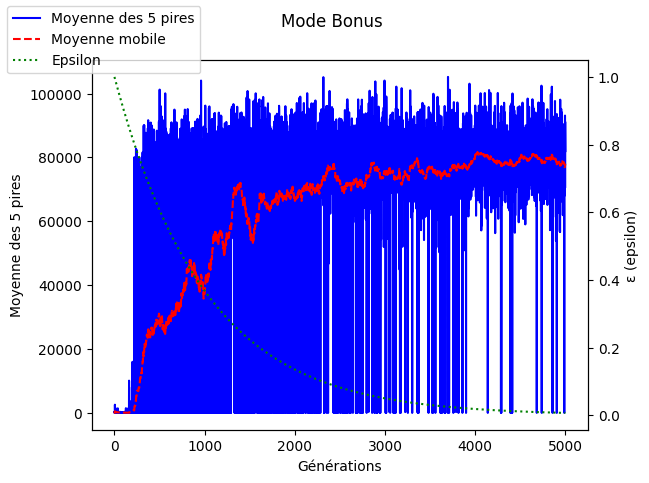

Lancement d'une partie avec les meilleurs coefficients ...
pygame 2.6.1 (SDL 2.28.4, Python 3.13.2)
Hello from the pygame community. https://www.pygame.org/contribute.html
Score final : 61557

--- Evaluating final weights over 100 games ---

✅ Final Weights Evaluation (100 games):
- Average score: 98694.16
- Standard deviation: 17179.39
- Min score: 61096
- Max score: 145982


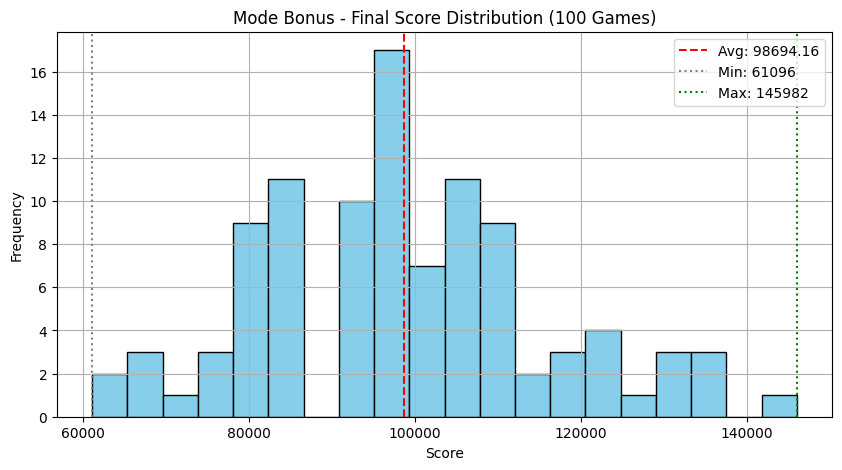

In [8]:
train_batches_best_average(run_game_function=run_game_classique_bonus, weight_size=7 , generations=5000, epsilon=1, epsilon_decay=0.999, name="Mode Bonus", nameOfTheFile="jeuClassiqueBonus.py")

In [ ]:
import random
import matplotlib.pyplot as plt
import json
import tempfile
import subprocess

def train_with_consistency_penalty(run_game_function, weight_size, generations=1000, epsilon=0, epsilon_decay=1, name="No Name", nameOfTheFile="jeuPowerUP.py", batch_size=10, k=1.0):
    best_weights = [random.uniform(-1, 1) for _ in range(weight_size)]
    best_composite_score = float('-inf')  # composite score based on average of worst - k * std

    epsilon_min = 0
    composite_scores = []   # List of composite scores
    moving_avg = []         # Moving average
    epsilons = []

    for gen in range(generations):
        epsilons.append(epsilon)

        # Exploration or exploitation
        if random.random() < epsilon:
            weights = [random.uniform(-2, 2) for _ in range(weight_size)]
        else:
            weights = [w + random.uniform(-0.2, 0.2) for w in best_weights]

        # Run a batch of games
        batch_scores = [run_game_function(weights) for _ in range(batch_size)]

        # Average of the 5 worst
        sorted_scores = sorted(batch_scores)
        avg_worst_5 = sum(sorted_scores[:5]) / 5

        # Standard deviation
        mean_score = sum(batch_scores) / batch_size
        std_dev = (sum((x - mean_score) ** 2 for x in batch_scores) / batch_size) ** 0.5

        # Composite score
        composite_score = avg_worst_5 - (k * std_dev)

        composite_scores.append(composite_score)
        moving_avg.append(sum(composite_scores[-100:]) / min(len(composite_scores), 100))

        print(f"Generation {gen} | Composite: {composite_score:.2f} | Avg worst 5: {avg_worst_5:.2f} | σ={std_dev:.2f} | ε={epsilon:.4f}")

        if composite_score > best_composite_score:
            best_composite_score = composite_score
            best_weights = weights
            print("🎯 New best composite score:", best_composite_score)

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print("\n--- Training complete ---")
    print("Best composite score:", best_composite_score)
    print("Final weights:", best_weights)

    final_weights = best_weights

    # Graph: Composite score and epsilon
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Generations")
    ax1.set_ylabel("Composite score")
    ax1.plot(composite_scores, label="Composite score", color='blue')
    ax1.plot(moving_avg, label="Moving average", color='red', linestyle='dashed')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel("ε (epsilon)")
    ax2.plot(epsilons, label="Epsilon", color='green', linestyle='dotted')
    ax2.tick_params(axis='y')

    fig.suptitle(name)
    fig.legend(loc='upper left')
    plt.show()

    # Save and run
    print("Launching a game with the best weights ...")
    with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.json') as f:
        json.dump(final_weights, f)
        temp_file_path = f.name

    subprocess.run(["python", nameOfTheFile, temp_file_path])

    # Final evaluation
    print("\n--- Final evaluation over 100 games ---")
    final_scores = [run_game_function(final_weights) for _ in range(100)]

    avg_score = sum(final_scores) / len(final_scores)
    std_dev = (sum((x - avg_score) ** 2 for x in final_scores) / len(final_scores)) ** 0.5
    min_score = min(final_scores)
    max_score = max(final_scores)

    print("\n✅ Final Weights Evaluation (100 games):")
    print(f"- Average: {avg_score:.2f}")
    print(f"- Standard deviation: {std_dev:.2f}")
    print(f"- Minimum score: {min_score}")
    print(f"- Maximum score: {max_score}")

    plt.figure(figsize=(10, 5))
    plt.hist(final_scores, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(avg_score, color='red', linestyle='dashed', linewidth=1.5, label=f"Average: {avg_score:.2f}")
    plt.axvline(min_score, color='gray', linestyle='dotted', linewidth=1.5, label=f"Min: {min_score}")
    plt.axvline(max_score, color='green', linestyle='dotted', linewidth=1.5, label=f"Max: {max_score}")
    plt.title(f"{name} - Final Score Distribution (100 games)")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
train_with_consistency_penalty(run_game_function=run_game_classique_bonus, weight_size=7 , generations=5000, epsilon=1, epsilon_decay=0.999, name="Mode Bonus", nameOfTheFile="jeuClassiqueBonus.py")